# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Lending Club Project


**Harvard University**<br/>
**Fall 2018**<br/>

<hr style="height:2pt">



In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [3]:
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
    
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
import time

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set()
import matplotlib.style
matplotlib.style.use('seaborn-whitegrid')
sns.set_style("white")
from IPython.display import display

<hr style="height:2pt">

<div class='theme'> Overview </div>

### This notebook contains the following sections:
* **Part 1**: Getting the data ready for modelling
* **Part 2**: Resampling the data to balance the classes
* **Part 3**: Generating scaled train/test splits


<div class='exercise'><b> Part 1: Getting the data ready for modelling </b></div>

The cleaned dataset still needs some pre-processing in order to make it ready for modelling. This includes:

* Removing several more columns that are not informative, for example where they duplicate other information or only have a single value
* Drop the last digits of the zip code
* Recoding some ordinal variables into numerical scales
* Recoding some categorical variables into dummy variables

In [4]:
# increase some display options to display all columns and more rows.
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 150

In [5]:
# Read in the data sets from local files
original_df = pd.read_csv('../data/data_cleaned_2016_2017.csv',low_memory=False)


In [6]:
# One function to do all of the above operations
def data_prep(df):
    
    # Definitions
    cols_to_remove = ['funded_amnt', 'funded_amnt_inv', 'num_sats', 
                   'application_type', 'num_actv_rev_tl', 'sec_app_num_rev_accts',
                     'pymnt_plan']
    nominal_columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state']
    prefixes = ['home', 'verify', 'purp', 'state']
    
    # Drop additional uninformative columns
    df = df.drop(columns=cols_to_remove)
    
    # strip xx from zip code
    df["zip_code"] = [x.strip("xx") for x in df["zip_code"].astype(str)]
    df["zip_code"] = df["zip_code"].astype(int)
    
    # exclude zip code from set of predictors for analysis
    # to be added back in later for checking discrimination...
    df = df.drop(columns='zip_code')

    
    # ordinal columns are encoded as numerical values, as there is an order
    df["grade"].replace({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}, inplace = True)
    df["sub_grade"].replace({"A1": 1, "A2": 2, "A3": 3, "A4": 4, "A5": 5,
                                "B1": 6, "B2": 7, "B3": 8, "B4": 9, "B5": 10,
                                "C1": 11, "C2": 12, "C3": 13, "C4": 14, "C5": 15,
                                "D1": 16, "D2": 17, "D3": 18, "D4": 19, "D5": 20,
                                "E1": 21, "E2": 22, "E3": 23, "E4": 24, "E5": 25,
                                "F1": 26, "F2": 27, "F3": 28, "F4": 29, "F5": 30,
                                "G1": 31, "G2": 32, "G3": 33, "G4": 34, "G5": 35}, inplace = True)

    # nominal columns are encoded via hot encoding by adding more columns
    df = pd.get_dummies(df, columns=nominal_columns, prefix=prefixes, drop_first=True)


    
    return df

In [7]:
df_all = data_prep(original_df)

<div class='exercise'><b> Part 2: Resample to achieve balanced classes </b></div>

Since we have imbalanced classes that can cause misleading assessment of model performance, we resample the classes here. We also take the opportunity to reduce the dataset size in the initial stages, so that different model specifications can be tested faster.

In [8]:
# Check balance of target values - it is unbalanced
df_all["loan_status"].value_counts().to_frame()

,loan_status
Fully Paid,255116
Charged Off,78993


In [9]:
# Downsample and create balanced classes
def balance_classes(df, n_samples):
    # Define majority and minority classes
    df_majority = df[df["loan_status"] == "Fully Paid"]
    df_minority = df[df["loan_status"] == "Charged Off"]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace = False,    # sample without replacement
                                     n_samples = n_samples,   
                                     random_state = 1) # set random seed for reproducability

    # Downsample minority class
    df_minority_downsampled = resample(df_minority, 
                                     replace = False,    # sample without replacement
                                     n_samples = n_samples,   
                                     random_state = 1) 

    # Recombine
    df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])

    return df_downsampled


In [10]:
# Define how many samples of each we want
n_samples = 10000

df = balance_classes(df_all, n_samples)

In [11]:
df["loan_status"].value_counts().to_frame()

,loan_status
Charged Off,10000
Fully Paid,10000


In [12]:
display(df.describe())

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,annual_inc_joint,dti_joint,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,home_MORTGAGE,home_NONE,home_OWN,home_RENT,verify_Source Verified,verify_Verified,purp_credit_card,purp_debt_consolidation,purp_home_improvement,purp_house,purp_major_purchase,purp_medical,purp_moving,purp_other,purp_renewable_energy,purp_small_business,purp_vacation,purp_wedding,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.0,20000.0,20000.0,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.0000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000
mean,14845.695000,0.262550,14.527035,459.439889,3.029100,13.132300,5.504275,7.711921e+04,2016.316400,19.428785,0.354800,2000.068650,0.647250,0.527850,0.210200,11.869650,0.266850,15585.475900,

<div class='exercise'><b> Part 3: Scale the data and generate train/test splits </b></div>

Since we will be using models that are sensitive to scale, we need to scale the data. This is done in a function for reproducability.

In [13]:
# Function to generate train test splits and scale the data
def get_train_test(df, test_size = 0.2):
    nonbinary_columns = ['loan_amnt','int_rate','installment','grade','sub_grade','emp_length','annual_inc',
 'issue_d','dti', 'delinq_2yrs','earliest_cr_line','inq_last_6mths', 'open_acc','pub_rec','revol_bal','revol_util','total_acc', 'annual_inc_joint','dti_joint','acc_now_delinq',
 'open_acc_6m','open_act_il', 'open_il_12m','open_il_24m', 'total_bal_il','il_util','open_rv_12m','open_rv_24m',
 'max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths',
 'delinq_amnt','mort_acc','num_accts_ever_120_pd', 'num_actv_bc_tl','num_bc_sats','num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
 'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'revol_bal_joint', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog',]

    
    # Train test split
    data_train, data_test = train_test_split(df, test_size = test_size, random_state = 1)
    
    # Split into x and y
    X_train = data_train.iloc[:, data_train.columns != 'loan_status']
    y_train = data_train['loan_status'].values
    X_test = data_test.iloc[:, data_test.columns != 'loan_status']
    y_test = data_test['loan_status'].values
    
    # Incorporate scaling here so that we can use it consistently across all models
    scaler = StandardScaler()
    X_train[nonbinary_columns] = scaler.fit_transform(X_train[nonbinary_columns])
    X_test[nonbinary_columns] = scaler.transform(X_test[nonbinary_columns])
    
    return X_train, y_train, X_test, y_test

In [14]:
# Create scaled train and test sets
X_train, y_train, X_test, y_test = get_train_test(df)


In [15]:
# Check that data has scaled correctly
display(X_train.describe())

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,annual_inc_joint,dti_joint,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,home_MORTGAGE,home_NONE,home_OWN,home_RENT,verify_Source Verified,verify_Verified,purp_credit_card,purp_debt_consolidation,purp_home_improvement,purp_house,purp_major_purchase,purp_medical,purp_moving,purp_other,purp_renewable_energy,purp_small_business,purp_vacation,purp_wedding,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
count,1.600000e+04,16000.000000,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,16000.000000,16000.000000,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,16000.000000,16000.000000,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,16000.000000,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,16000.0,16000.0,16000.0,16000.0,1.600000e+04,16000.000000,16000.000000,16000.000000,16000.000000,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.0,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.00000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,-8.243406e-17,0.261000,-2.559480e-16,-8.903989e-17,2.926548e-16,-2.555595e-17,-4.130030e-17,4.838838e-17,-3.533851e-14,-2.584443e-16,3.158099e-16,-4.493956e-15,9.364731e-17,0

In [16]:
# Check by running a basic random forest (without tuning parameters)
rf = RandomForestClassifier(n_estimators=int(X_train.shape[1]/2), 
                            max_depth = 2).fit(X_train, y_train)
print("The precision score for the basic RF is:")
precision_score(rf.predict(X_test), y_test, pos_label = "Fully Paid")

The precision score for the basic RF is:


0.5330073349633252

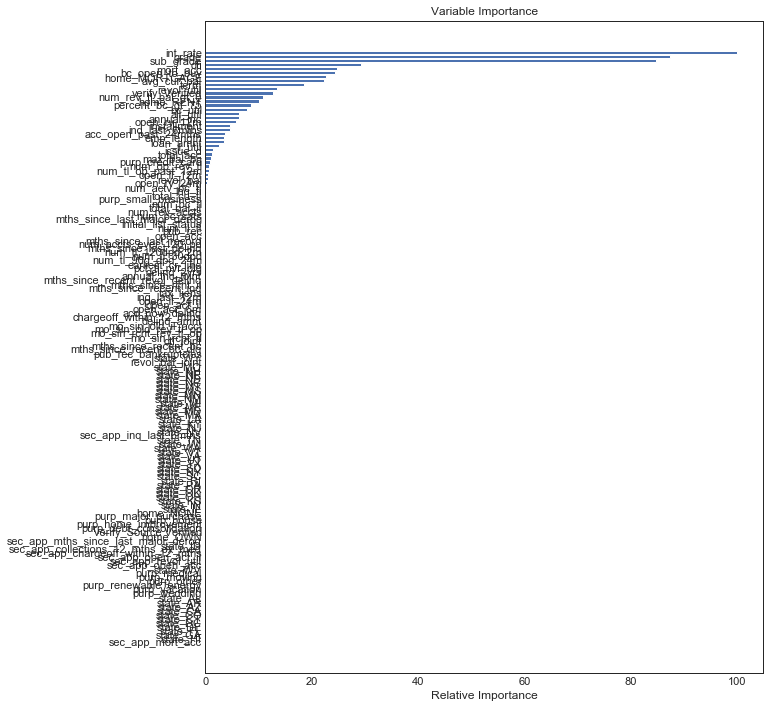

In [17]:
# Check that the top features make sense
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [19]:
# Simple logistic regression with everything included, no regularisation
baseline_LR = LogisticRegression().fit(X_train, y_train)

print("The precision score for the basic logistic regression is:")
precision_score(baseline_LR.predict(X_test), y_test, pos_label = "Fully Paid")

The precision score for the basic logistic regression is:


0.6479217603911981